## **0. Introduction**

This notebook serves the purpose of exploring the data used in the master thesis. For now I will look into the dataset from [Kosti et al., 2017](https://openaccess.thecvf.com/content_cvpr_2017/papers/Kosti_Emotion_Recognition_in_CVPR_2017_paper.pdf), the data can be requested [here](https://docs.google.com/forms/d/e/1FAIpQLScXwxhEZu7RpHwgiRqVfb09GzHSSyIm64hJQMgHSLm75ltsFQ/viewform).

There are different types of image folders. At first I will investigate the "emodb_small" folder. This contains mostly images, in which the face is clearly visible.

In [1]:
import os
os.chdir('/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis/kosti/emodb_small/images')

In [2]:
len(os.listdir())

864

In [3]:
os.chdir('/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis/kosti/mat2csv/emotic/mscoco/images')

The emod_small folder contains 861 images.

In [4]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

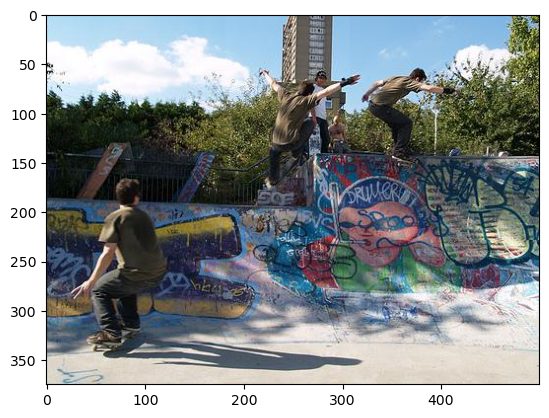

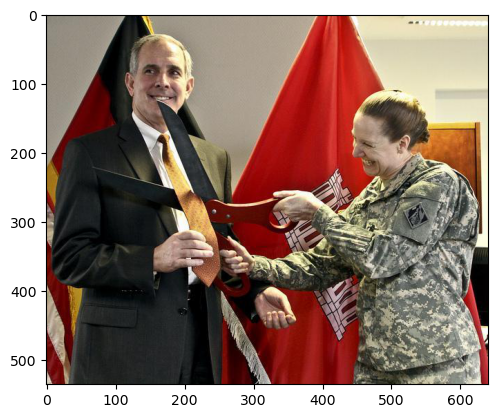

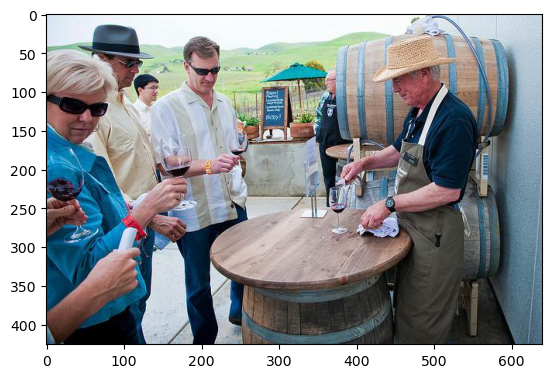

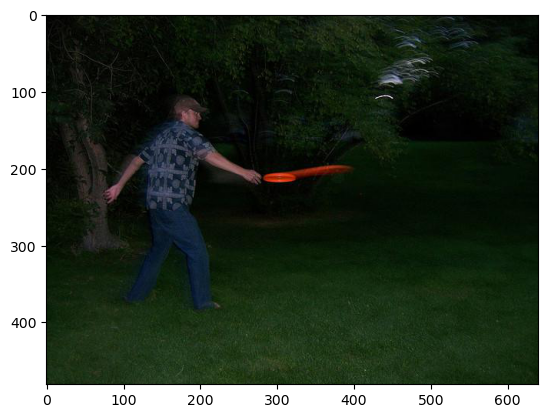

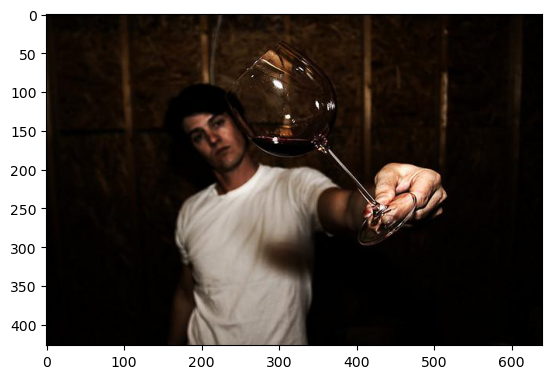

In [17]:
j=0
X = []
for img in os.listdir():
    image = mpimg.imread(img)
    plt.imshow(image)
    plt.show()
    j = j +1
    X.append(img)
    if j == 5:
        break
        
        

In [18]:
X

['COCO_train2014_000000000077.jpg',
 'COCO_train2014_000000000165.jpg',
 'COCO_train2014_000000000308.jpg',
 'COCO_train2014_000000000322.jpg',
 'COCO_train2014_000000000326.jpg']

Lets try Alexnet for the object classification on the 5 images.
The following code cells are heavily inspired by this pytorch [tutorial](https://pytorch.org/hub/pytorch_vision_alexnet/).

In [6]:
import torch

model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

In [7]:
from PIL import Image
from torchvision import transforms

input_image = Image.open(X[0])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0]);
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0);
print(probabilities);

# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

**Salience Examination**

Since YOLO implementation did not work for now, I will focus on the salience extraction. The following is heavily inspired by this [notebook](https://github.com/sunnynevarekar/pytorch-saliency-maps/blob/master/Saliency_maps_in_pytorch.ipynb)

In [8]:
import torchvision

In [9]:
#load pretrained resnet model
model = torchvision.models.resnet50(pretrained=True)
print(model)

#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,          
])



/home/jpauli/miniconda3/envs/yolo/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jpauli/miniconda3/envs/yolo/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [11]:
from PIL import Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


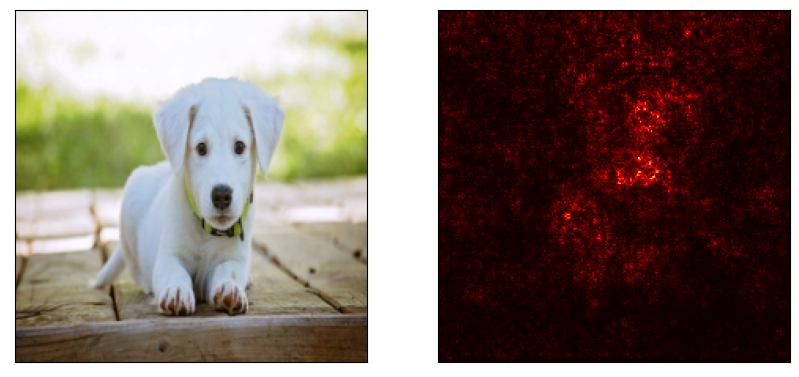

In [13]:
img = Image.open("/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis/puppy.jpg").convert('RGB')
saliency(img,model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


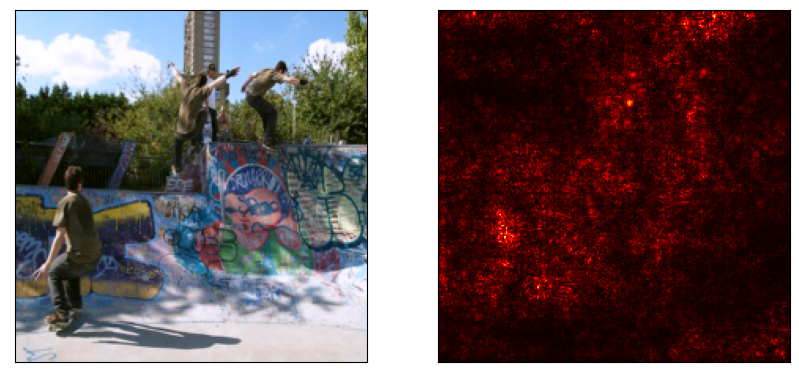

In [19]:
i = Image.open(X[0]).convert('RGB')
saliency(i,model)

In [16]:
i



**Note:**

The annotations are stored in a struct within a .mat file. There exists a pytorch implementation, that stores .py file which transform the mat files into csv files. Please follow this [link](https://github.com/Tandon-A/emotic) to the respective github repository. After I assembled the images and annotations in the demanded structure, I ran the mat2py file and ended up with a training, validation and test csv file.


In [ ]:
os.chdir('/mnt/c/Users/janos/OneDrive/Desktop/Master_thesis/kosti/mat2csv/emotic_pre/')

In [ ]:
os.listdir()

We will now inspect the 'train.csv' file.

In [ ]:
import pandas as pd
train = pd.read_csv('train.csv')

In [ ]:
print('The training data consists of {} images.'.format(train.shape[0]))

In [ ]:
train.head(n=10)

We see that the training set not only contains the continous and categorial labels, but the respective image. Since we may want to take adavantage of the different image type for each "folder", we could extract the respective folder with the labels. Meaning we have 4 csv files for each folder type. 

In [ ]:
train['Folder'].unique()